In [36]:
import numpy as np
from game_code.game_simulation import simulation
import matplotlib.pyplot as plt
np.random.seed(42)
print(simulation(np.ones(21)))

80


### I. Introduction

$\bullet$ Firstly, we have configured the Tetris game, as depicted in `game_code`. The pivotal piece of code is `game_simulation`, which takes a vector $w$ as input. This vector governs the `value_function`, thereby facilitating action selection in Tetris.

$\bullet$ The `value_function` is defined by $V(w)=\sum_{i=1}^{10} w_{i}h_{i} + \sum_{i=1}^{9} w_{i+10}$ $\Delta$  $h_{i}$ $+w_{20}H+w_{21}M$
with $h_{p}$ for $p$ $\in$ $\{1, 2, \ldots, n\}$ is height of the pth column of the board, $\Delta$  $h_{p}=h_{p+1}-h_{p}$, $H$ is the number of empty cells covered by at least one full cell and $M$ is the maximum pile height: $max_{p} h_{p}$. Therefore, for each new piece, we drop the piece with the position that minimize this function.

$\bullet$ Henceforth, from this, we want to maximize the score of a Tetris game. A game is random, so the problem is :
$max_{w} \mathbb{E}(S(w))$ with S the score function.

$\bullet$ Thus, to solve numerically this problem, we implement 2 main methods, cross entropy method and simulated annealing.


### II. Cross entropy method

[Have a look at this following link to see the theoretical aspect of the cross entropy method.](https://people.smp.uq.edu.au/DirkKroese/ps/CEopt.pdf)


Iteration 1: Average score of best samples: 1.9
Iteration 2: Average score of best samples: 3.3
Iteration 3: Average score of best samples: 4.5
Iteration 4: Average score of best samples: 11.2
Iteration 5: Average score of best samples: 19.9
Iteration 6: Average score of best samples: 20.9
Iteration 7: Average score of best samples: 30.8
Iteration 8: Average score of best samples: 33.5
Iteration 9: Average score of best samples: 33.5
Iteration 10: Average score of best samples: 35.6


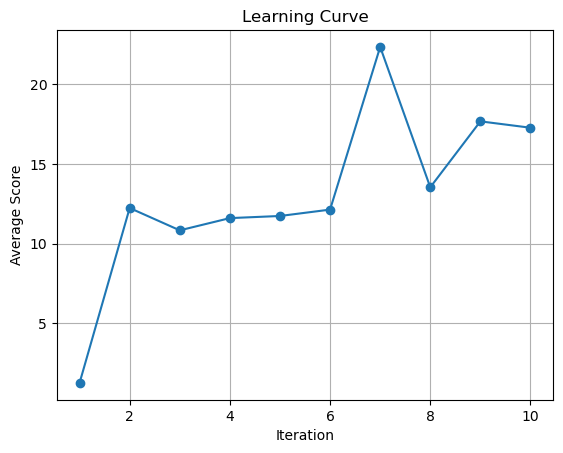

In [37]:
# Number of samples
N = 100
# Proportion of best samples to select
rho = 0.1
# Number of iterations
iterations = 10
# Number of games to play to compute the learning curve
num_games = 30

# Initialize the parameter vector w to zero
w = np.zeros(21)
# Initialize the covariance matrix Sigma to 100 * I
Sigma = 100 * np.eye(21)

learning_curve = []

for t in range(iterations):
    # Generate samples from the current Gaussian distribution
    samples = np.random.multivariate_normal(w, Sigma, N)
    
    # Evaluate each sample with the score function (game simulation)
    scores = np.array([simulation(sample) for sample in samples])
    
    # Sort samples based on their score and select the best ones
    best_samples_indices = np.argsort(scores)[-int(N * rho):]
    best_samples = samples[best_samples_indices]
    
    # Update w with the empirical mean of the selected best samples
    w = np.mean(best_samples, axis=0)
    
    # Update Sigma with the empirical covariance of the selected best samples
    Sigma = np.cov(best_samples, rowvar=False)

    # Compute the learning curve with the mean weights of the new distribution
    # Play num_games games with these mean weights and record the scores
    game_scores = [simulation(w) for _ in range(num_games)]
    learning_curve.append(np.mean(game_scores))

    # Print the average score of the best samples at each iteration
    print("Iteration {}: Average score of best samples: {}".format(t+1, np.mean(scores[best_samples_indices])))

# Plot the learning curve
plt.plot(range(1, iterations+1), learning_curve, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Average Score')
plt.title('Learning Curve')
plt.grid(True)
plt.show()


In [41]:
print(simulation(np.ones(21)))

137
